In [1]:
import pandas as pd
import mapply
mapply.init(progressbar=True, max_chunks_per_worker=100)

/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clean = pd.read_feather('../data/lyrics_cleaned.feather')
clean = clean[clean['tag'] != 'misc']
# clean = clean[clean['tag'] != 'pop']

In [16]:
from sklearn.model_selection import train_test_split

SUBSAMPLE = 0.001

ds = clean.drop(['tokens', 'id'], axis=1)

TRAIN_P, VALID_P, TEST_P = 0.6, 0.2, 0.2
LABEL = 'tag'

ds = ds.rename(columns={LABEL: 'label'})
LABEL = 'label'

ds[LABEL], labels_map = pd.factorize(ds[LABEL])

assert TRAIN_P + VALID_P + TEST_P == 1

dev_ds, test_ds = train_test_split(ds, test_size=TEST_P, random_state=0, stratify=ds[LABEL])
train_ds, valid_ds = train_test_split(dev_ds, test_size=(VALID_P / (TRAIN_P + VALID_P)), random_state=0, stratify=dev_ds[LABEL])
  
if SUBSAMPLE:
  train_ds, _ = train_test_split(train_ds, train_size=SUBSAMPLE, random_state=0, stratify=train_ds[LABEL])
  valid_ds, _ = train_test_split(valid_ds, train_size=SUBSAMPLE, random_state=0, stratify=valid_ds[LABEL])
  test_ds, _ = train_test_split(test_ds, train_size=SUBSAMPLE, random_state=0, stratify=test_ds[LABEL])

In [4]:
from datasets import Dataset, DatasetDict

dataset_dict = {}
dataset_dict['train'] = Dataset.from_pandas(train_ds, split = 'Train').remove_columns(['__index_level_0__'])
dataset_dict['valid'] = Dataset.from_pandas(valid_ds, split = 'Validation').remove_columns(['__index_level_0__'])
dataset_dict['test'] = Dataset.from_pandas(test_ds, split = 'Test').remove_columns(['__index_level_0__'])

datasets = DatasetDict(dataset_dict)
datasets


DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 42
    })
    valid: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 14
    })
    test: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 14
    })
})

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datetime import datetime

# MODEL = "FacebookAI/roberta-base"
# MODEL = "google-bert/bert-base-uncased"
MODEL = "distilbert/distilgpt2"
MODEL_DIR = '../NAS/' + str(datetime.now()) + '/' + MODEL.split('/')[-1]
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id


def tokenize(row):
  return tokenizer(row['lyrics_clean'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = datasets.map(tokenize, batched=True)

Map: 100%|██████████| 14/14 [00:00<00:00, 1589.48 examples/s]


In [6]:
from transformers import TrainingArguments, AutoModelForSequenceClassification

training_args = TrainingArguments(MODEL_DIR, save_strategy='no')

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels = labels_map.shape[0])

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def optuna_hp_space(trial):
  return {        
    "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
    "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4]),  
  }

In [9]:
import numpy as np

class AlmostAccuracy:
  def __call__(self, eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    true = np.abs(preds - labels) == 0
    return {"accuracy": true.astype(np.float32).mean().item()}

from transformers import Trainer

def model_init(_):
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels = labels_map.shape[0])
    TRAIN_ONLY_HEAD = False

    if TRAIN_ONLY_HEAD:
      for name, param in model.named_parameters():
        if 'classifier' not in name:
          param.requires_grad = False
        else:
          param.requires_grad = True
        model.config.pad_token_id = model.config.eos_token_id
    return model

trainer = Trainer(
  args=training_args,
  train_dataset=tokenized_datasets['train'],
  eval_dataset=tokenized_datasets['valid'],
  data_collator=data_collator,
  tokenizer=tokenizer,
  model_init=model_init,
  compute_metrics=AlmostAccuracy()
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from typing import List, Dict
import transformers

# trainer.train()
transformers.logging.set_verbosity_error()
def compute_objective(metrics: Dict[str, float]) -> List[float]:
  return metrics["eval_loss"], metrics["eval_accuracy"]

from datetime import datetime

best_trials = trainer.hyperparameter_search(
  direction=["minimize", "maximize"],
  backend="optuna",
  hp_space=optuna_hp_space,
  n_trials=1,
  compute_objective=compute_objective,
  storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
  study_name=f"GPT2",
  load_if_exists=False
)

[I 2024-05-30 16:01:42,658] A new study created in RDB with name: GPT2


Step,Training Loss


[I 2024-05-30 16:01:53,801] Trial 0 finished with values: [2.332435369491577, 0.3571428656578064] and parameters: {'learning_rate': 4.35235178588917e-06, 'per_device_train_batch_size': 4}. 


In [21]:
ds = clean.drop(['tokens', 'id'], axis=1)

SUBSAMPLE = 0.005

TRAIN_P, VALID_P, TEST_P = 0.6, 0.2, 0.2
LABEL = 'tag'

ds = ds.rename(columns={LABEL: 'label'})
LABEL = 'label'

ds[LABEL], labels_map = pd.factorize(ds[LABEL])

assert TRAIN_P + VALID_P + TEST_P == 1

dev_ds, test_ds = train_test_split(ds, test_size=TEST_P, random_state=0, stratify=ds[LABEL])
  
if SUBSAMPLE:
  dev_ds, _ = train_test_split(dev_ds, train_size=SUBSAMPLE, random_state=0, stratify=dev_ds[LABEL])
  test_ds, _ = train_test_split(test_ds, train_size=SUBSAMPLE, random_state=0, stratify=test_ds[LABEL])


dataset_dict = {}
dataset_dict['dev'] = Dataset.from_pandas(dev_ds, split = 'Dev').remove_columns(['__index_level_0__'])
dataset_dict['test'] = Dataset.from_pandas(test_ds, split = 'Test').remove_columns(['__index_level_0__'])

datasets = DatasetDict(dataset_dict)
tokenized_datasets = datasets.map(tokenize, batched=True)

training_args = TrainingArguments(MODEL_DIR, **best_trials[0].hyperparameters)
trainer = Trainer(
  model=model_init(None),
  args=training_args,
  train_dataset=tokenized_datasets['dev'],
  eval_dataset=tokenized_datasets['test'],
  data_collator=data_collator,
  tokenizer=tokenizer,
  compute_metrics=AlmostAccuracy()
)
trainer.train()

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map: 100%|██████████| 70/70 [00:00<00:00, 2762.92 examples/s]


{'train_runtime': 60.6207, 'train_samples_per_second': 13.857, 'train_steps_per_second': 3.464, 'train_loss': 2.395024181547619, 'epoch': 3.0}


TrainOutput(global_step=210, training_loss=2.395024181547619, metrics={'train_runtime': 60.6207, 'train_samples_per_second': 13.857, 'train_steps_per_second': 3.464, 'train_loss': 2.395024181547619, 'epoch': 3.0})

In [22]:
import numpy as np

predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)

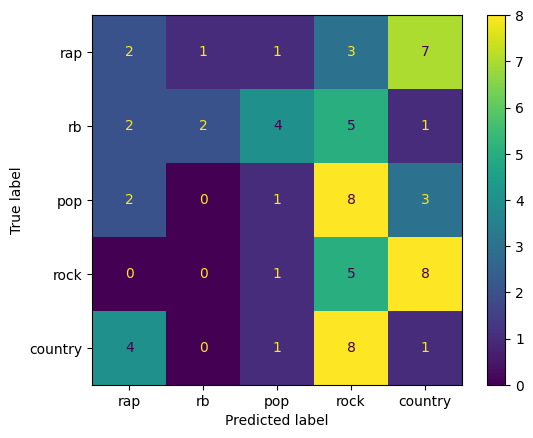

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(predictions.label_ids, preds),
                              display_labels=labels_map)
disp.plot()


In [24]:
from sklearn.metrics import classification_report

print(classification_report(predictions.label_ids, preds, target_names=labels_map))

              precision    recall  f1-score   support

         rap       0.20      0.14      0.17        14
          rb       0.67      0.14      0.24        14
         pop       0.12      0.07      0.09        14
        rock       0.17      0.36      0.23        14
     country       0.05      0.07      0.06        14

    accuracy                           0.16        70
   macro avg       0.24      0.16      0.16        70
weighted avg       0.24      0.16      0.16        70



In [15]:
trainer.save_model(MODEL_DIR + '/best')